## Load Libraries

In [1]:
import os
import json
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
%matplotlib inline

In [2]:
from tqdm import tqdm
import re
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Helper functions


### KL divergence

Here, we use the sample distribution of the model and the empirical distribution of the 
human subjects and assume their empirical mean and variances are the mean and variance of a normal approximation to the population distribution.  Then we use the KL divergence to fit the model

Let $p(x) = N(x; \mu_1, \sigma_1)$ be the human data and $q(x) = N(x; \mu_2, \sigma_2)$ be the model we are using to approximate the human data.  We are minimzing the KL with

$$KL(p||q) = -\int_x p(x) \ln \frac{q(x)}{p(x)}$$

which, with Gaussians is equal to 

$$KL(p||q) = \ln \frac{\sigma_2}{\sigma_1} + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2\sigma^2_2} - \frac{1}{2}$$




In [3]:
def kl_pq(mu_1, mu_2, sd_1, sd_2):
    # p(x) = N(x; mu_1, sd_1)
    # q(x) = N(x; mu_2, sd_2)
    
    return np.log(sd_2) - np.log(sd_1) + \
        (sd_1 ** 2 + (mu_1 - mu_2)**2) / (2 * (sd_2**2) ) - 0.5

# Load data -- Trial by Trial

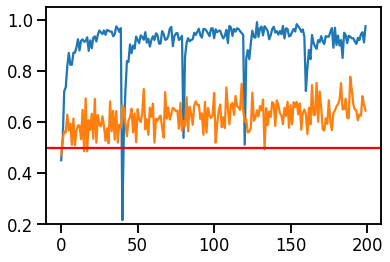

In [4]:
# human behavior data
human_tbt = pd.read_csv('./gsdata/nickdata/BehDataTrialXTrial.csv', index_col=1)
human_tbt.columns = human_tbt.columns.str.lower()

## mean and sd of blocked/interleaved
human_blocked_M = human_tbt.loc[:, '{} mean'.format('blocked')].values
human_blocked_S = human_tbt.loc[:, '{} stddev'.format('blocked')].values
human_interleaved_M = human_tbt.loc[:, '{} mean'.format('interleaved')].values
human_interleaved_S = human_tbt.loc[:, '{} stddev'.format('interleaved')].values

plt.plot(human_blocked_M)
plt.plot(human_interleaved_M)
plt.ylim(0.2,1.05)
plt.axhline(0.5,c='r')

### parse file string to uncover parameter set 

In [5]:
def parse_file_str(file_str):
  D = {}
  fsplit = file_str.split('_')
#   print(fsplit)
  D['cond'] = str(fsplit[-10])
  D['seed'] = int(fsplit[-1].split('.')[0])
  D['alfa'] = parse_alfa(fsplit[-4])
  D['lmbda'] = float(fsplit[-3])
  D['lr'] = float(fsplit[-8])
  D['nepochs'] = int(fsplit[-6])
  return D

def parse_alfa(alfa_str):
  asplit = alfa_str.split('-')
  if len(asplit)==3:
    alfa = -float(asplit[1])
  elif len(asplit)==2:
    alfa = float(asplit[0])
  else:
    print(asplit)
  return alfa

In [6]:
def create_gsdf(gs_name,debug=False):
  """ 
  create single long dataframe 
  with data from all models
  """
  model_dfL = []
  fpathL = glob('gsdata/%s/t*'%gs_name)
  if debug: fpathL = fpathL[:100]
  for idx,fpath in enumerate(fpathL):
    param_dict = parse_file_str(fpath)
    model_data = pd.read_csv(fpath)
    # populate model_dat with param_dict
    for name,val in param_dict.items():
      model_data.loc[:,name] = val
    model_data.loc[:,'model_idx'] = idx
    model_dfL.append(model_data)
  gsdf = pd.concat(model_dfL)
  return gsdf

In [7]:
# # save
# gsdf = create_gsdf('sem1')
# gsdf.to_csv('gsdata/sem1/gsdf-sem1')
# load
# gsdf = pd.read_csv('gsdata/sem1/gsdf-sem1')
# gsdf.shape

In [78]:
sample_size_df = gsdf[(gsdf.t==0)].groupby(
  ['condition','alfa','lmbda','nepochs','lr','t']
).seed.count()
from collections import Counter
# Counter([i[4] for i in sample_size_df[sample_size_df<10].index])

Counter({0.001: 495, 0.005: 135})

In [11]:
def get_accdf(gs_name):
  """
  mean over seeds and conditions
  """
  gsdf = pd.read_csv('gsdata/%s/gsdf-sem1'%gs_name)
  ## initialize accuracy mean and std over seeds
  group_gsdf = gsdf.groupby(['condition','alfa','lmbda','nepochs','lr','t'])
  acc_df = pd.concat([
      group_gsdf.accuracy.mean(),
      group_gsdf.accuracy.std()
    ],keys=['mu','stdev'],axis=1
  ).reset_index(-1)
  ## calculate MSE for each parameter 
  for param_tuple in acc_df.index.unique():
#     print(param_tuple)
    human_mean = human_tbt.loc[:, '{} mean'.format(param_tuple[0])].values
    human_std = human_tbt.loc[:, '{} stddev'.format(param_tuple[0])].values
    model_df = acc_df.loc[param_tuple]
    # calc MSE and KL
    acc_df.loc[param_tuple,'MSE'] = np.mean((human_mean - model_df.mu) ** 2)
    acc_df.loc[param_tuple,'KL'] = np.sum(
      kl_pq(human_mean, model_df.mu, human_std, model_df.stdev))
  return acc_df

In [12]:
acc_df = get_accdf('sem1')
acc_df

t        mu     stdev      MSE  \
condition   alfa  lmbda nepochs lr                                        
blocked     -32.0 -32.0 1       0.001    0  0.023057  0.004655  0.31270   
                                0.001    1  0.983556  0.020601  0.31270   
                                0.001    2  0.024816  0.001553  0.31270   
                                0.001    3  0.980623  0.024686  0.31270   
                                0.001    4  0.979061  0.026827  0.31270   
...                                    ...       ...       ...      ...   
interleaved  32.0  32.0 64      0.001  195  0.959670  0.013685  0.04029   
                                0.001  196  0.985501  0.001528  0.04029   
                                0.001  197  0.963471  0.013859  0.04029   
                                0.001  198  0.988556  0.000533  0.04029   
                                0.001  199  0.940714  0.066692  0.04029   

                                                 KL  
condition   alfa  lmbda nepochs lr                   
blocked     -32.0 -32.0 1       0.001  1.147544e+06  
                                0.001  1.147544e+06  
                                0.001  1.147544e+06  
                                0.001  1.147544e+06  
                                0.001  1.147544e+06  
...                                             ...  
interleaved  32.0  32.0 64      0.001  1.908070e+07  
                                0.001  1.908070e+07  
                                0.001  1.908070e+07  
                                0.001  1.908070e+07  
                                0.001  1.908070e+07  

[852000 rows x 5 columns]

### find min err params

In [13]:
"""
min error across seeds/conditions
collapse over blocked/interleaved
"""
err_df = acc_df.groupby(['alfa','lmbda','nepochs','lr']).sum()
min_err = err_df.loc[:,('MSE','KL')].min()
print('-min_err\n',min_err)

minimizing_params = err_df[err_df.MSE==min_err.MSE].index
print('-params\n',minimizing_params)

# num_seeds = sample_size.loc[('blocked',*minimizing_params)].values[0]
# print('-num_seeds',num_seeds)

-min_err
 MSE    4.070448
KL     0.000000
dtype: float64
-params
 MultiIndex([(32.0, 32.0, 16, 0.005)],
           names=['alfa', 'lmbda', 'nepochs', 'lr'])


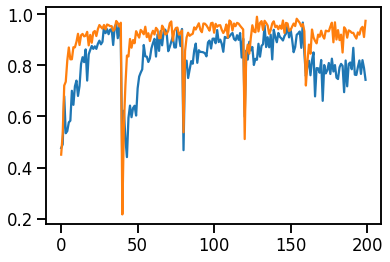

In [14]:
plt.plot(acc_df.loc[('blocked',*minimizing_params[0]),:].mu.values)
plt.plot(human_blocked_M)

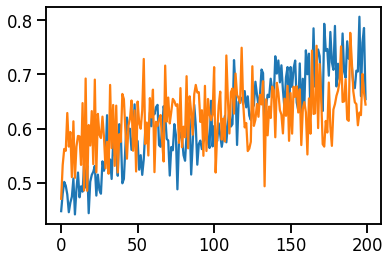

In [15]:
plt.plot(acc_df.loc[('interleaved',*minimizing_params[0]),:].mu.values)
plt.plot(human_interleaved_M)

In [13]:
assert False

AssertionError: 


### compute error metrics 

In [ ]:
def get_KL_and_MSE(file):
  """ 
  returns error metrics (KL and MSE) for given parameter_set
  """
  # load model trial-by-trial data
  model_data = pd.read_csv(file)
  model_data.columns = model_data.columns.str.lower()
  # sum MSE and KL across conditions
  MSE = 0
  KL = 0
  model_grouped = model_data.groupby(['condition', 't'])
  for cond in ['blocked', 'interleaved']:
      # model mean and std 
      mu_model = model_grouped.mean().loc[cond]['accuracy'].values
      sd_model = model_grouped.std().loc[cond]['accuracy'].values
      # human mean and std
      mu_beh = trial_by_trial.loc[:, '{} mean'.format(cond)].values
      sd_beh = trial_by_trial.loc[:, '{} stddev'.format(cond)].values
      # add error over conditions
      MSE += np.mean((mu_beh - mu_model) ** 2)
      KL  += np.sum(kl_pq(mu_beh, mu_model, sd_beh, sd_model))
  return {
    'MSE':MSE,
    'KL':KL
  }


In [ ]:
""" 
make results_df: 
  dataframe with fitting data from all models 
"""

head_dir = './data/gridsearch_full1/'
trial_files = glob(head_dir + 'trial*csv')
files.sort()

L = []
for file in trial_files:
  err_dict = get_KL_and_MSE(file)
  param_dict = parse_file_str(file)
  L.append({**param_dict,**err_dict})
results_df = pd.pandas.DataFrame(L)

### NB Nick's code had a bug, so that he was using MSE instead of KL

In [ ]:
results_df.groupby('model_type')['MSE'].min()

In [ ]:
results_df.groupby('model_type')['KL'].min()

### get model with min error

In [ ]:
def get_min_err_model(model_type,eval_metric):
  """ returns trial-by-trial dataframe 
  with info from best fit model
  """
  min_err = results_df.groupby('model_type')[eval_metric].min()[model_type]
  _,lr,nep,alfa,lmbda,_,_ = results_df[results_df[eval_metric] == min_err].values[0]
  fpath = "trial_X_trial_%s-lr-%.3f-nepchs-%i-alpha-%.3f-lambda-%.3f.csv"%(
            model_type,lr,nep,alfa,lmbda)
  print(fpath)
  df = pd.read_csv(head_dir+'/'+fpath)
  return df


In [ ]:
model_df = get_min_err_model('LSTM','MSE')
model_df

In [ ]:
sns.relplot(data=model_df[model_df.Condition=='blocked'],
            x='t', y='Accuracy', kind='line', aspect=2, height=3)
plt.ylim(0.4,1)

# nick

In [ ]:
assert False

In [ ]:
#LSTM
model = 'LSTM'
tXt_Loss.loc[(tXt_Loss.model == model) & (tXt_Loss.KL == min_vals[model])]

In [ ]:
#SEM
model = 'SEM'
tXt_Loss.loc[(tXt_Loss.model == model) & (tXt_Loss.KL == min_vals[model])]

In [ ]:
#MLP
model = 'MLP'
tXt_Loss.loc[(tXt_Loss.model == model) & (tXt_Loss.KL == min_vals[model])]

In [ ]:
def get_data(model):
    theta = tXt_Loss.loc[(tXt_Loss.model == model) & (tXt_Loss.KL == min_vals[model])]
    lr, n_epochs, logalpha, loglamda = \
        theta.loc[:, 'lr n_epochs logalpha loglamda'.split()].values[0]
    
    model_name = ['VanillaLSTM', 'MLP'][model == 'MLP']
    no_split_tag = ['_nosplit', ''][model == 'SEM']
    
    args = [lr, int(n_epochs), float(logalpha), float(loglamda),no_split_tag]
#     hdir = 'data/'
    file = '{}trial_X_trial_{}_nhiddenNone_e1e-05_lr'.format(path, model_name)
    file += '{}_n{}_d0.0_logalfa_{}_loglmda_{}_{}_online.csv'.format(*args)
#     return file
    return pd.read_csv(file)


In [ ]:
get_data('SEM')

In [ ]:
def plot_acc_by_time(model, condition):
    df = get_data(model)
    sns.relplot(data=df[df.Condition==condition],
            x='t', y='Accuracy', kind='line', aspect=2, height=3)
    plt.title(condition)
    plt.xlabel('Story')
    plt.ylim(0, 1.0)
    plt.xlim(0, 200)
    return plt.gcf()

def plot_pe_by_time(model, condition):
    df = get_data(model)
    sns.relplot(data=df[df.Condition==condition],
            x='t', y='pe', kind='line', aspect=2, height=3)
    plt.title(condition)
    plt.xlabel('Story')
    plt.ylabel('Prediction Error')
    plt.xlim(0, 200)
    plt.ylim(0, 1)
    return plt.gcf()

In [ ]:
df = get_data("SEM")
sns.relplot(data=df, hue='Condition',
        x='t', y='Accuracy', kind='line', aspect=2, height=3)
plt.title('SEM')

In [ ]:
df = get_data("LSTM")
sns.relplot(data=df, hue='Condition',
        x='t', y='Accuracy', kind='line', aspect=2, height=3)
plt.title('LSTM')

In [ ]:
df = get_data("MLP")
sns.relplot(data=df, hue='Condition',
        x='t', y='Accuracy', kind='line', aspect=2, height=3)
plt.title('MLP')

## Model fitting: Blocked/Interleaved Only

In [ ]:
# Load files one at a time
tXt_Loss_BIonly = []
sim = 0
files = glob(path + 'trial*csv')

def get_error(file):

    model_data = pd.read_csv(file)
    model_grouped = model_data.groupby(['Condition', 't'])

    
    MSE = 0
    KL = 0

    for cond in ['Blocked', 'Interleaved']:
        mu_model = model_grouped.mean().loc[cond]['Accuracy'].values
        sd_model = model_grouped.std().loc[cond]['Accuracy'].values

        mu_beh = trial_by_trial.loc[:, '{} Mean'.format(cond)].values
        sd_beh = trial_by_trial.loc[:, '{} StdDev'.format(cond)].values

        MSE += np.mean((mu_beh - mu_model) ** 2)
        KL  += np.sum(kl_pq(mu_beh, mu_model, sd_beh, sd_model))

    return {
            'KL': MSE,
            'MSE': KL,
        }


for file in tqdm(files):
    
    idx = file.find('nhidden') + 7
    n_hidden = pull_from_start(file, idx)
    if n_hidden == 'None':
        n_hidden = 10
    else:
        n_hidden = int(pull_from_start(file, idx))
    
    # learning rate -- this we can't find a reliable end point beyond 
    # "_" charaecter
    idx = file.find('_lr') + 3
    lr = float(pull_from_start(file, idx))

    # n_epochs
    idx = file[idx:].find('_n') + idx + 2
    n = int(pull_from_start(file, idx))

    # dropout
    idx = file[idx:].find('_d') + idx + 2
    d = float(pull_from_start(file, idx))

    # loglmda
    idx = file.find('_loglmda') + 9
    loglamda =float(pull_from_start(file, idx))

    # logalpha
    idx = file.find('_logalfa') + 9
    idx2 = file.find('_loglmda')
    logalpha = float(file[idx:idx2])       
    
    # epsilon
    idx = file.find('_e') + 2
    epsilon = float(pull_from_start(file, idx))

    _tXt = get_error(file)
    _tXt['lr'] = lr
    _tXt['n_epochs'] = n
    _tXt['dropout'] = d
    _tXt['epsilon'] = epsilon
    _tXt['loglamda'] = loglamda
    _tXt['logalpha'] = logalpha
    _tXt['sim'] = sim
    _tXt['n_hidden'] = n_hidden
    _tXt['model'] = get_model(file)

    tXt_Loss_BIonly.append(_tXt)
    sim += 1
    
#     break
tXt_Loss_BIonly = pd.DataFrame(tXt_Loss_BIonly)
tXt_Loss_BIonly.index = range(len(tXt_Loss_BIonly))




In [ ]:
min_vals_BIonly = tXt_Loss_BIonly.groupby('model')['MSE'].min()
min_vals_BIonly

In [ ]:

def get_data(model, fits_df, metric='KL'):
    
    min_vals = fits_df.groupby('model')[metric].min()
    theta = fits_df.loc[(fits_df.model == model) & (fits_df[metric] == min_vals[model])]
    lr, n_epochs, logalpha, loglamda = \
        theta.loc[:, 'lr n_epochs logalpha loglamda'.split()].values[0]
    print(lr, n_epochs, logalpha, loglamda)
    
    model_name = ['VanillaLSTM', 'MLP'][model == 'MLP']
    no_split_tag = ['_nosplit', ''][model == 'SEM']
    
    args = [lr, int(n_epochs), float(logalpha), float(loglamda),no_split_tag]
    
    file = '{}trial_X_trial_{}_nhiddenNone_e1e-05_lr'.format(path, model_name)
    file += '{}_n{}_d0.0_logalfa_{}_loglmda_{}_{}_online_instructed.csv'.format(*args)

    return pd.read_csv(file)



In [ ]:
df = get_data("MLP", tXt_Loss_BIonly)
sns.relplot(data=df, hue='Condition',
        x='t', y='Accuracy', kind='line', aspect=2, height=3)
plt.title('MLP')

In [ ]:
df = get_data("SEM", tXt_Loss_BIonly)
sns.relplot(data=df, hue='Condition',
        x='t', y='Accuracy', kind='line', aspect=2, height=3)
plt.title('SEM')

In [ ]:
df = get_data("LSTM", tXt_Loss_BIonly)
sns.relplot(data=df, hue='Condition',
        x='t', y='Accuracy', kind='line', aspect=2, height=3)
plt.title('LSTM')